In [ ]:
!gdown --id 10fKUF1u3uhIrhEipoklNgysmPyYuYGV9 -O kaggle_m3.zip
!gdown --id 1Leaos-3uB70Lex1qLE7FvrtaOBDOYKbQ -O data_aug.zip

In [ ]:
! mkdir fakes
! cp data_aug.zip fakes
%cd fakes
! ls

/content/fakes
data_aug.zip


In [ ]:
! unzip data_aug.zip

In [ ]:
%cd ..

/content


In [ ]:
!unzip kaggle_m3.zip

# Import Dataset

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
import pandas as pd
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,Conv2DTranspose, Concatenate, Activation, Dropout, Flatten, Dense, Input,concatenate, UpSampling2D
from keras.callbacks import EarlyStopping
import tensorflow as tf

import os
import cv2
from PIL import Image
import numpy as np

In [2]:
# Set parameters
file_path='/'
Size = (256, 256)
mask_files = glob(file_path + os.path.join('content','*','*_mask*'))
train_files = [file.replace('_mask', '') for file in mask_files]


def label(mask):
    value = np.max(cv2.imread(mask))
    return 1 if value > 0 else 0
df = pd.DataFrame({"image": train_files,
                   "mask": mask_files,
                  "label":[label(x) for x in mask_files]})

df.shape

(5302, 3)

# Split Data

Due to the lack of memory problem, we have to use Keras `ImageDataGenerator` to dynamically load images in each epoch.

reference: 
* How to use `ImageDataGenerator`: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
* How to combine mask and image together: https://stackoverflow.com/questions/56517963/keras-imagedatagenerator-for-segmentation-with-images-and-masks-in-separate-dire




## Split the dataframe first

In [3]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.1)
df_test, df_val = train_test_split(df_test, test_size=0.5)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(4771, 3)
(266, 3)
(265, 3)


## Helper function: zip image generator and mask generator

In [4]:
def image_mask_generator(image_data_generator, mask_data_generator):
    train_generator = zip(image_data_generator, mask_data_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

In [5]:
SEED = 8
EPOCHS = 60
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
IMAGE_COLOR_MODE = "rgb"
MASK_COLOR_MODE = "grayscale"

## Train Generator

In [6]:
train_image_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=60,
        horizontal_flip=True,
        vertical_flip=True).flow_from_dataframe(df_train, x_col = "image", class_mode = None, color_mode = IMAGE_COLOR_MODE, batch_size = BATCH_SIZE, target_size = Size, seed = SEED)

train_mask_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=60,
        horizontal_flip=True,
        vertical_flip=True).flow_from_dataframe(df_train, x_col = "mask", class_mode = None, color_mode = MASK_COLOR_MODE, batch_size = BATCH_SIZE, target_size = Size, seed = SEED)

train_gen = image_mask_generator(train_image_generator, train_mask_generator)

Found 4771 validated image filenames.
Found 4771 validated image filenames.


## Validation Generator

In [7]:
val_image_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(df_val, x_col = "image", class_mode = None, color_mode = IMAGE_COLOR_MODE, batch_size = BATCH_SIZE, target_size = Size, seed = SEED)
val_mask_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(df_val, x_col = "mask", class_mode = None, color_mode = MASK_COLOR_MODE, batch_size = BATCH_SIZE, target_size = Size, seed = SEED)

val_gen = image_mask_generator(val_image_generator, val_mask_generator)

Found 266 validated image filenames.
Found 266 validated image filenames.


## Test Generator

In [8]:
test_image_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(df_test, x_col = "image", class_mode = None, color_mode = IMAGE_COLOR_MODE, batch_size = BATCH_SIZE, target_size = Size, seed = SEED)
test_mask_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(df_test, x_col = "mask", class_mode = None, color_mode = MASK_COLOR_MODE, batch_size = BATCH_SIZE, target_size = Size, seed = SEED)

test_gen = image_mask_generator(test_image_generator, test_mask_generator)

Found 265 validated image filenames.
Found 265 validated image filenames.


# Segmentation

## Helper functions: Plot graphs

In [32]:
def plot_loss_and_acurracy(history):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
  epochs = range(len(history.history['loss']))

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  axes[0].plot(epochs, loss, 'y', label='Training loss')
  axes[0].plot(epochs, val_loss, 'r', label='Validation loss')
  axes[0].set_title('Training and validation loss')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Loss')
  axes[0].legend()

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  axes[1].plot(epochs, acc, 'y', label='Training acc')
  axes[1].plot(epochs, val_acc, 'r', label='Validation acc')
  axes[1].set_title('Training and validation accuracy')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('Accuracy')
  axes[1].legend()

## Helper functions: Unit block 

In [9]:
def convolutional_layer(input, filter_nums):
    output = Conv2D(filter_nums, 3, padding="same", kernel_initializer = 'he_normal')(input)
    output = Activation("relu")(output)

    output = Conv2D(filter_nums, 3, padding="same", kernel_initializer = 'he_normal')(output)
    output = Activation("relu")(output)
    return output


def encoder_layer(input, filter_nums, has_drop_out=False, drop_value=0.5):
    output = convolutional_layer(input, filter_nums)
    if has_drop_out: 
      drop = Dropout(drop_value)(output)
      pool = MaxPooling2D((2, 2))(drop)
      return output, pool
    else:
      pool = MaxPooling2D((2, 2))(output)
      return output, pool 
    

def decoder_layer(input, conte_feature, filter_nums):
    conv_tran = Conv2DTranspose(filter_nums, (2, 2), strides=2, padding="same", kernel_initializer = 'he_normal')(input)
    uconv = Concatenate()([conv_tran, conte_feature])
    output = convolutional_layer(uconv, filter_nums)
    return output

## U-Net Builder

In [10]:
INPUT_SHAPE = (256, 256, 3)
def build_unet():
    inputs = Input(INPUT_SHAPE)
    
    # Encoder process
    con1, pool1 = encoder_layer(inputs, 64)
    con2, pool2 = encoder_layer(pool1, 128)
    con3, pool3 = encoder_layer(pool2, 256)
    con4, pool4 = encoder_layer(pool3, 512, True)

    # Bridge/Middle
    bridge = convolutional_layer(pool4, 1024) 
    drop5 = Dropout(0.5)(bridge)

    # Decoder process
    dec1 = decoder_layer(drop5, con4, 512)
    dec2 = decoder_layer(dec1, con3, 256)
    dec3 = decoder_layer(dec2, con2, 128)
    dec4 = decoder_layer(dec3, con1, 64)

    outputs = Conv2D(1, 1, padding="same", activation='sigmoid')(dec4) 
    model = Model(inputs, outputs, name="U-Net")
    return model


## EarlyStopping

In [11]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

## Optimizer - Adam

In [12]:
opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, amsgrad=True)

## Metrics

In [13]:
from keras import backend as K
smooth=1.

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def IoU(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

metrics = ['accuracy', IoU, dice_coef, tf.keras.metrics.MeanIoU(num_classes=2)]

## Train Model

In [14]:
model = build_unet()

In [15]:
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=metrics)

In [16]:
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) // BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=[es],
                    validation_data = val_gen,
                    validation_steps=len(df_val) // BATCH_SIZE)

Epoch 1/60
149/149 [==============================] - 116s 723ms/step - loss: 0.0980 - accuracy: 0.9682 - IoU: 0.0896 - dice_coef: 0.1571 - mean_io_u: 0.4929 - val_loss: 0.0434 - val_accuracy: 0.9888 - val_IoU: 0.1694 - val_dice_coef: 0.2886 - val_mean_io_u: 0.4919
Epoch 2/60
149/149 [==============================] - 107s 717ms/step - loss: 0.0317 - accuracy: 0.9890 - IoU: 0.2827 - dice_coef: 0.4355 - mean_io_u: 0.4929 - val_loss: 0.0276 - val_accuracy: 0.9909 - val_IoU: 0.3729 - val_dice_coef: 0.5429 - val_mean_io_u: 0.4916
Epoch 3/60
149/149 [==============================] - 107s 716ms/step - loss: 0.0267 - accuracy: 0.9903 - IoU: 0.3738 - dice_coef: 0.5402 - mean_io_u: 0.4929 - val_loss: 0.0325 - val_accuracy: 0.9897 - val_IoU: 0.3397 - val_dice_coef: 0.5067 - val_mean_io_u: 0.4918
Epoch 4/60
149/149 [==============================] - 107s 715ms/step - loss: 0.0235 - accuracy: 0.9910 - IoU: 0.4185 - dice_coef: 0.5861 - mean_io_u: 0.4928 - val_loss: 0.0302 - val_accuracy: 0.9897 - 

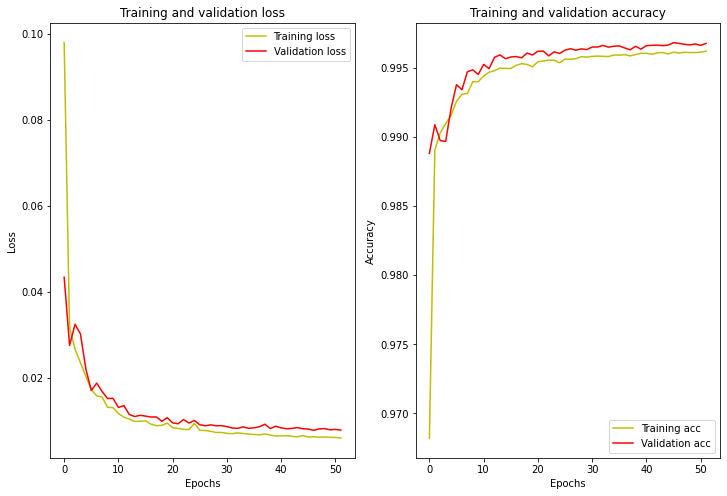

In [33]:
plot_loss_and_acurracy(history)

In [34]:
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)

8/8 [==============================] - 2s 249ms/step - loss: 0.0064 - accuracy: 0.9974 - IoU: 0.7523 - dice_coef: 0.8580 - mean_io_u: 0.4952


## Sanity check

In [26]:
def show_prediction(df):
    index=np.random.randint(1,len(df.index))
    img = cv2.imread(df['image'].iloc[index])
    img = cv2.resize(img ,Size)
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

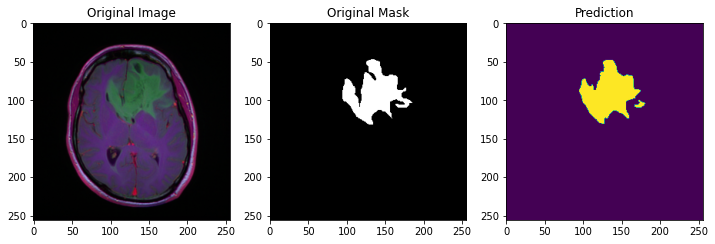

In [31]:
show_prediction(df_test)

# CLassification with segmentation

In [22]:
My_X_test = [ cv2.imread(path) for path in df_test["image"]  ]
My_y_test = df_test["label"].values

My_X_test = np.array(My_X_test) / 255.0

print(My_X_test.shape)
print(My_y_test.shape)

(265, 256, 256, 3)
(265,)


In [19]:
class MyModel:
  def __init__(self, model) -> None:
      self.model = model

  def predict(self, images):
      final_pred = []
      y_pred = self.model.predict(images)
      for idx in range(y_pred.shape[0]):
        pred_mask = y_pred[idx]
        result = 1 if np.max(pred_mask.reshape(-1)) > 0.1 else 0
        final_pred.append(result)
      
      return np.array(final_pred)

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
def plot_confusion_matraix(model, X_test, y_test, threshold=0.5):
    y_pred = model.predict(X_test)
    # y_pred = np.where(np.max(y_pred.reshape(-1)) >= threshold, 1, 0)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cm, range(2),range(2))
    plt.figure(figsize = (10,10))
    # plt.xlabel("Predicted Label")
    # plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    s = sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='g') # font size
    s.set(xlabel='Predicted Label', ylabel='True Label')

              precision    recall  f1-score   support

           0       1.00      0.81      0.90       135
           1       0.84      1.00      0.91       130

    accuracy                           0.91       265
   macro avg       0.92      0.91      0.91       265
weighted avg       0.92      0.91      0.90       265



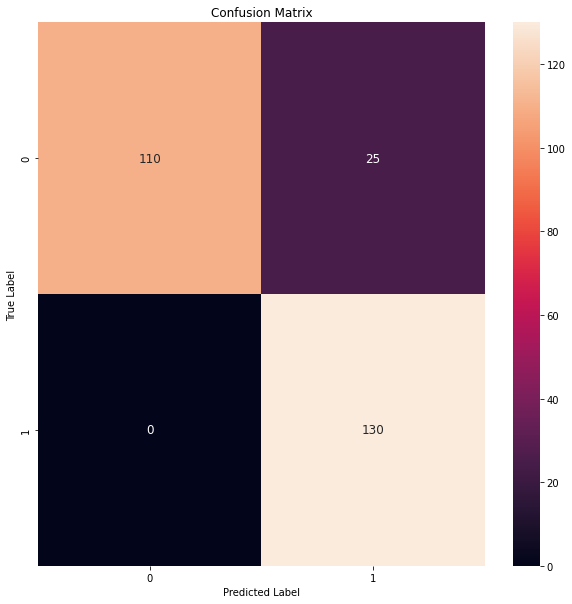

In [23]:
my_model = MyModel(model)

plot_confusion_matraix(my_model, My_X_test, My_y_test)

# Save model to my drive

In [35]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [36]:
! pwd

/content


In [38]:
model.save('new_brainMRI_Segment.h5')